# A coupling inversion tutorial

In [5]:
# Import externals
import numpy as np
import copy
import os

# Colormaps
from cmcrameri import cm

# Import personal libraries
import csi.TriangularPatches as triangleFault
import csi.fault3D as rectFault
import csi.transformation as transformation
import csi.geodeticplot as geoplt
import csi.gps as onegps
import csi.insar as insar
import csi.multifaultsolve as multiflt

os.chdir('/Users/romainjolivet/MYBIN/csi/notebooks')

## Some informations required

In [6]:
# Here we just provide some elements needed for the code to run

# Origin of the local coordinate system
lon0 = -70.
lat0 = -20.

# Geometry
faultGeometry = os.path.join(os.getcwd(), 'DataAndModels/InversionCoupling/megathrust.gocad')
edgeGeometry = os.path.join(os.getcwd(), 'DataAndModels/InversionCoupling/edgefault.txt')

# Data GNSS 
gnssData = os.path.join(os.getcwd(), 'DataAndModels/InversionCoupling/Northern.enu')
sarData = {'filename': os.path.join(os.getcwd(), 'DataAndModels/InversionCoupling/insar'),
           'sigma': 0.316663320126,
           'lambda':6.94320681868}

# Convergence from Metois et al 2012
# 67 mm/yr, azimuth 78deg
# minus the sliver motion --> 56 mm/yr
convergence = [78., 56.]


## Building the fault objects

In [7]:
# We first initialize a fault with triangular patches
fault = triangleFault('Megathrust', lon0=lon0, lat0=lat0)

# We read the triangular patches from the output format of the Gocad software.
# There is other reading methods
fault.readGocadPatches(faultGeometry, utm=False,factor_depth=1.)

# We initialize the slip on the fault with zeros
fault.initializeslip(values='depth')

# We build the trace of the fault. The shallowest patches are 
fault.setTrace(delta_depth=3)
fault.trace2ll()

# For further plotting
fault.linewidth=2
fault.color='r'

---------------------------------
---------------------------------
Initializing fault Megathrust


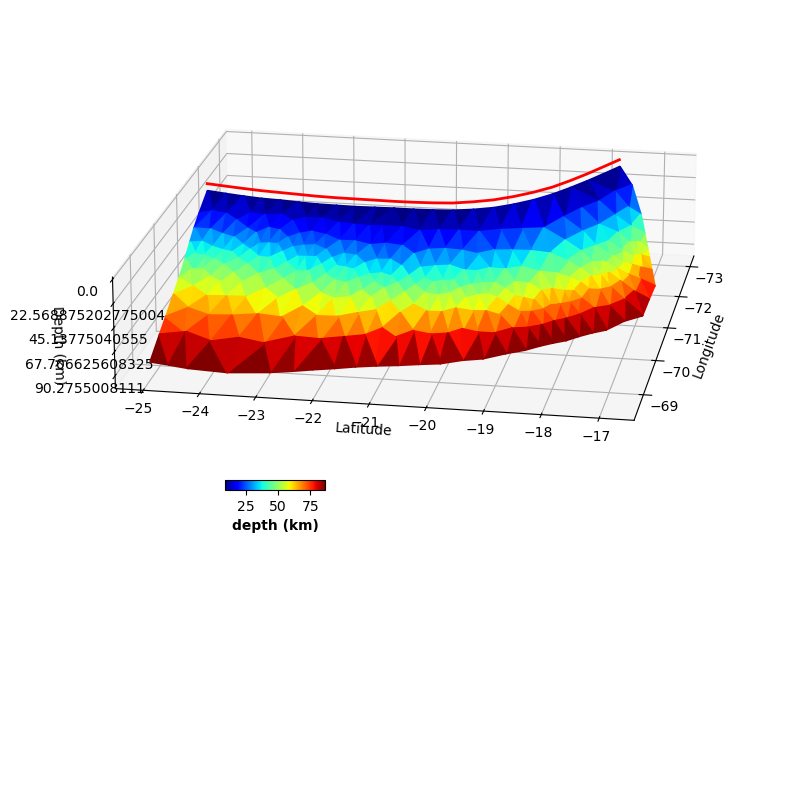

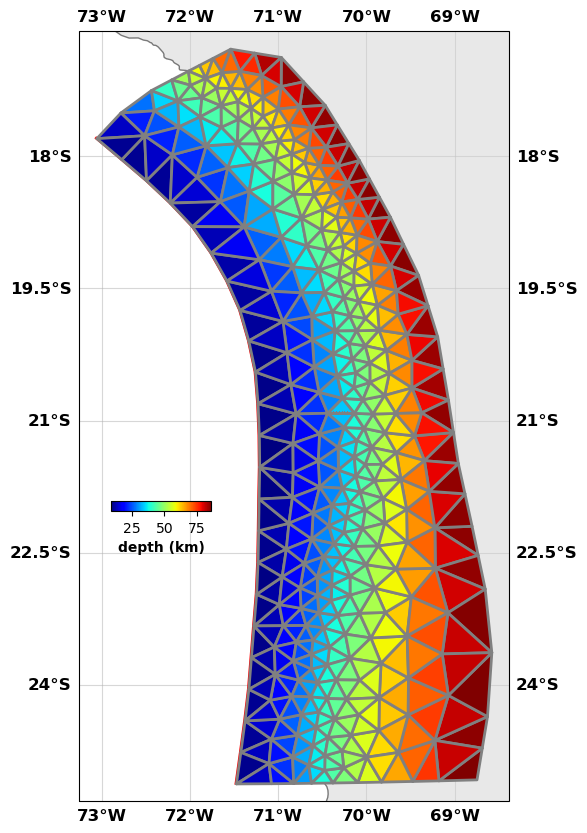

In [23]:
fault.plot(figsize=((10,10),(10,10)), view={'elevation': 20, 'azimuth': 10}, shape=(1, 1, 0.3), cbaxis=[0.33, 0.4, 0.1, 0.01], cblabel='depth (km)')

In [9]:
# The coupling problem has a lot of edge effects so we add some elements on the side to absorb them
edge = rectFault('Edges', lon0=lon0, lat0=lat0)

# This is a method reading from a text file
edge.readPatchesFromFile(edgeGeometry, readpatchindex=False, donotreadslip=True)


---------------------------------
---------------------------------
Initializing fault Edges


## Building the data objects

In [10]:
# Create the gnss object
gnss = onegps('GNSS data', lon0=lon0, lat0=lat0)

# Read the data
gnss.read_from_enu(gnssData, factor=1., header=1, checkNaNs=False)

# We don't want to use the vertical component
gnss.vel_enu[:,2] = np.nan

# We build a covariance matrix for the east and north components 
gnss.buildCd(direction='en')

---------------------------------
---------------------------------
Initialize GPS array GNSS data
Read data from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/InversionCoupling/Northern.enu into data set GNSS data


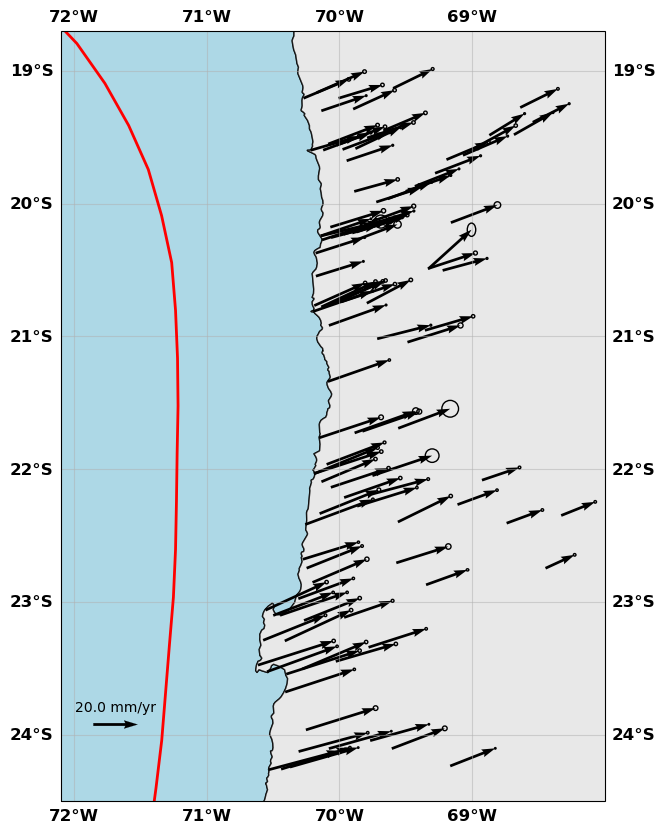

In [11]:
# Show me
gnss.plot(faults=fault, figsize=(10,10), seacolor='lightblue', title=None, box=[-72.1, -68., -24.5, -18.7], legendscale=20., legendunit='mm/yr', scale=60)

In [12]:
# Create an insar object. 
sar = insar('InSAR data', lon0=lon0, lat0=lat0)

# read the data from the downsampled file. We have downsampled the full res InSAR velocity map
# See the InSAR tutorial to see how that works 
sar.read_from_varres(sarData['filename'], factor=1.0)

# We build a data covaraince matrix using the information from the covariance calcualtion
# See the InSAR tutorial to see how that works
sar.buildCd(sarData['sigma'], sarData['lambda'])


---------------------------------
---------------------------------
Initialize InSAR data set InSAR data
Read from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/InversionCoupling/insar into data set InSAR data


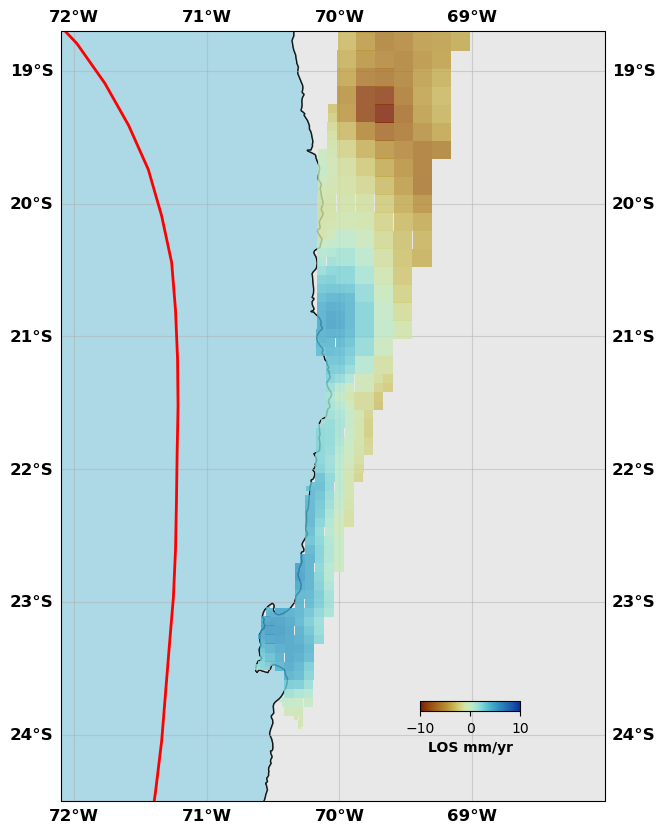

In [13]:
# Show me
sar.plot(plotType='decimate', faults=fault, box=[-72.1, -68., -24.5, -18.7], edgewidth=0, figsize=(10,10), cmap=cm.roma, norm=(-10,10),
         colorbar=True, cbaxis=[0.6, 0.2, 0.1, 0.01], cblabel='LOS mm/yr', seacolor='lightblue', alpha=0.8)

## Create a transformation object

In [14]:
# Initialize transformation object 
transform = transformation('All transforms', lon0=lon0, lat0=lat0)

---------------------------------
---------------------------------
Initializing transformation All transforms


## Build the Green's functions 

In [15]:
# Build the GFs for the transformation part
transform.buildGFs([gnss, sar], ['translationrotation', 1])

In [16]:
# The slip direction is 'c' in reference for coupling. 
# Convergence is here a tuple of direction and convergence rate. it can be an array the size of the numnber of patches with 2 columns
fault.buildGFs(gnss, method='meade', vertical=False, slipdir='c', convergence=convergence)
fault.buildGFs(sar, method='meade', vertical=True, slipdir='c', convergence=convergence)
edge.buildGFs(gnss, method='okada', vertical=False, slipdir='c', convergence=convergence)
edge.buildGFs(sar, method='okada', vertical=True, slipdir='c', convergence=convergence)

Greens functions computation method: meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
GNSS data of type gps in a homogeneous half-space
 Patch: 1 / 556 

 Patch: 556 / 556  
Greens functions computation method: meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
InSAR data of type insar in a homogeneous half-space
 Patch: 556 / 556  
Greens functions computation method: okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
GNSS data of type gps in a homogeneous half-space
 Patch: 8 / 8  
Greens functions computation method: okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
InSAR data of type insar in a homogeneous half-space
 Patch: 8 / 8  


## Solver 

### Assembling the problem

In [17]:
# We need now to assemble the problem

# Green's functions fault
edge.assembleGFs([gnss, sar], slipdir='c')
fault.assembleGFs([gnss, sar], slipdir='c')
transform.assembleGFs([gnss, sar])

# Data vectors
edge.assembled([gnss, sar])
fault.assembled([gnss, sar])
transform.assembled([gnss, sar])

# Data covariance matr
edge.assembleCd([gnss, sar])
fault.assembleCd([gnss, sar])
transform.assembleCd([gnss, sar])

---------------------------------
---------------------------------
Assembling G for fault Edges
Dealing with GNSS data of type gps
Dealing with InSAR data of type insar
---------------------------------
---------------------------------
Assembling G for fault Megathrust
Dealing with GNSS data of type gps
Dealing with InSAR data of type insar
---------------------------------
---------------------------------
Assembling G for transformation All transforms
---------------------------------
---------------------------------
Assembling d vector
Dealing with data GNSS data
Dealing with data InSAR data
---------------------------------
---------------------------------
Assembling d vector
Dealing with data GNSS data
Dealing with data InSAR data
---------------------------------
---------------------------------
Assembling d vector
Dealing with data GNSS data
Dealing with data InSAR data


### Regularization

There is no fancy regularization implemented yet in CSI since I do all my slip inversions with AlTar (which is designed to avoid smoothing and other dampings).
Here, we only have the approach by Radiguet et al 2010.


In [18]:
# Build a model covariance

# For the fault, we use a 10 mm sigma and a 20 km smoothing distance
fault.buildCm(1., 20.)

# For the edges, we use a 10 mm sigma and a 40 km smoothing distance
edge.buildCm(1., 40.)

# For transofmr, we use a Gaussian prior with a 100 variance (large)
transform.buildCm(100.)

---------------------------------
---------------------------------
Assembling the Cm matrix 
Sigma = 1.0
Lambda = 20.0
Lambda0 = 1.7946601468315058
---------------------------------
---------------------------------
Assembling the Cm matrix 
Sigma = 1.0
Lambda = 40.0
Lambda0 = 159.1631677112316



### Solver creation


In [19]:
# Create a solver object that will assemble the full problem
slv = multiflt('Coupling Northern Chile', [edge, fault, transform])
slv.assembleGFs()
slv.assembleCm()

---------------------------------
---------------------------------
Initializing solver object
Not a fault detected
Number of data: 635
Number of parameters: 568
Parameter Description ----------------------------------
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Edges                         ||None        ||None        ||None        ||   0 -    8 ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Megathrust                    ||None        ||None        ||None        ||   8 -  564 ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
All transforms                ||None        ||None        ||None        ||None        || 564 -  568 


### Problem solving

Here, we first solve the Generalized least squares problem first to get an good a priori. Then, we use ConstrainedLeastSquares to solve the problem for coupling being between 0 and 1.
It takes a bit of time because we have a lot of parameters. 

In [20]:
# Solve the Generalized least square problem for a priori
slv.GeneralizedLeastSquareSoln()

# Create a list of tuples for the bounds
bounds = []
for i in range(edge.N_slip):
    bounds.append([0.0, 1.0])
for i in range(fault.N_slip):
    bounds.append([0.0, 1.0])
for i in range(transform.TransformationParameters):
    bounds.append([-1000., 1000.])
    
# Get the prior model
mprior = slv.mpost.copy()

# Solve
slv.ConstrainedLeastSquareSoln(bounds=bounds,  
                               iterations=2000, 
                               method='L-BFGS-B', 
                               mprior=mprior,
                               tolerance=1e-07,
                               maxfun=1e10, 
                               checkIter=True)

---------------------------------
---------------------------------
Computing the Generalized Inverse
Computing the inverse of the model covariance
Computing the inverse of the data covariance
Computing m_post
---------------------------------
---------------------------------
Computing the Constrained least squares solution
Final data space size: 635
Final model space size: 568
Computing the inverse of the model covariance
Computing the inverse of the data covariance
Performing constrained minimzation
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          568     M =           10

At X0       204 variables are exactly at the bounds

At iterate    0    f=  4.23787D+03    |proj g|=  9.51858D+02

At iterate    1    f=  3.86096D+03    |proj g|=  1.05903D+02

At iterate    2    f=  3.25515D+03    |proj g|=  1.26229D+02

At iterate    3    f=  2.23039D+03    |proj g|=  1.99656D+02

At iterate    4    f=  2.07175D+03    |proj g|=  2.12526D+02

At iterate    

In [21]:
# Distribute
slv.distributem(verbose=True)

# Remove the transformation
transform.removePredictions([gnss, sar])

# Compute Synthetics
for data in [gnss, sar]: data.buildsynth(slv.faults, direction='c')

---------------------------------
---------------------------------
Distribute the slip values to fault Edges
---------------------------------
---------------------------------
Distribute the slip values to fault Megathrust
---------------------------------
---------------------------------
Distribute the slip values to fault All transforms


### Show me the resutls

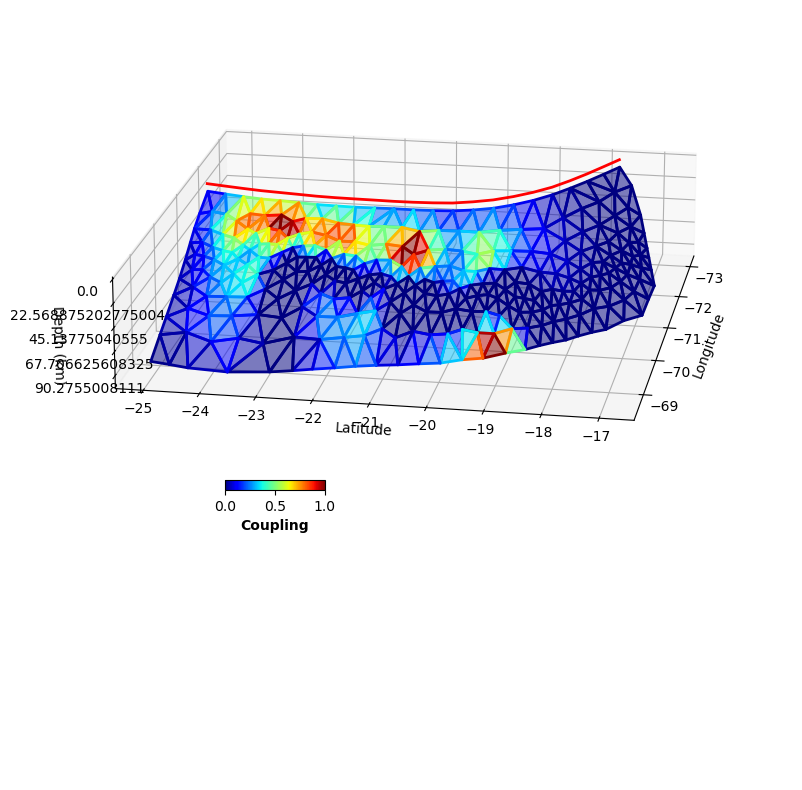

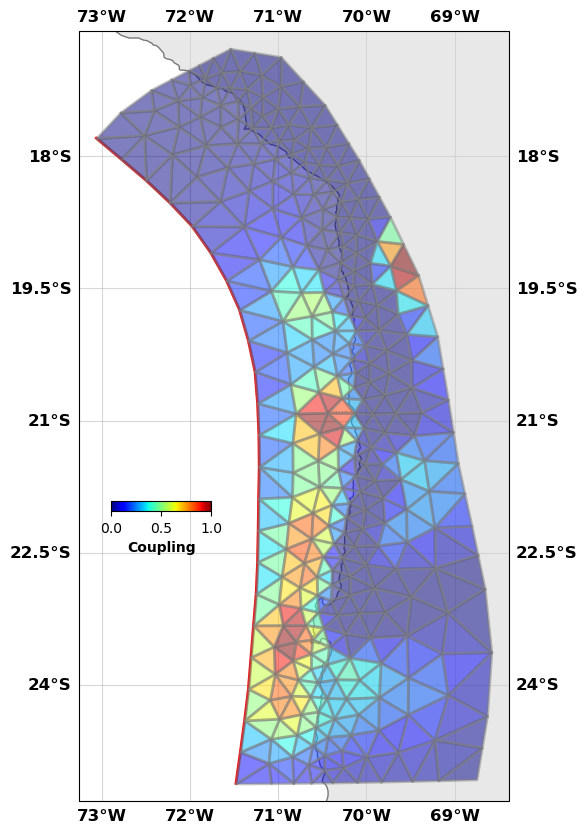

In [24]:
fault.plot(slip='c', 
           figsize=((10,10),(10,10)), alpha=0.5,
           view={'elevation': 20, 'azimuth': 10}, shape=(1, 1, 0.3), 
           cbaxis=[0.33, 0.4, 0.1, 0.01], cblabel='Coupling')

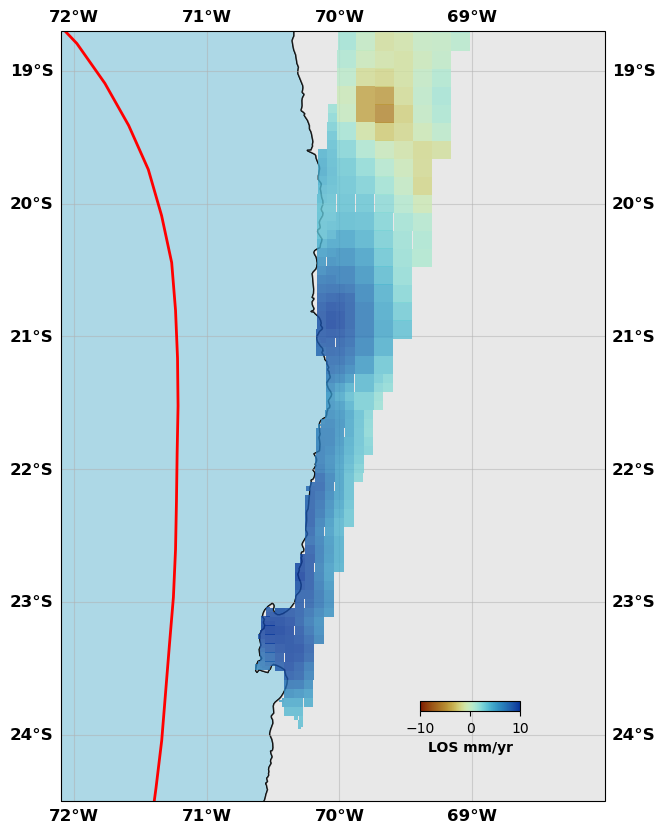

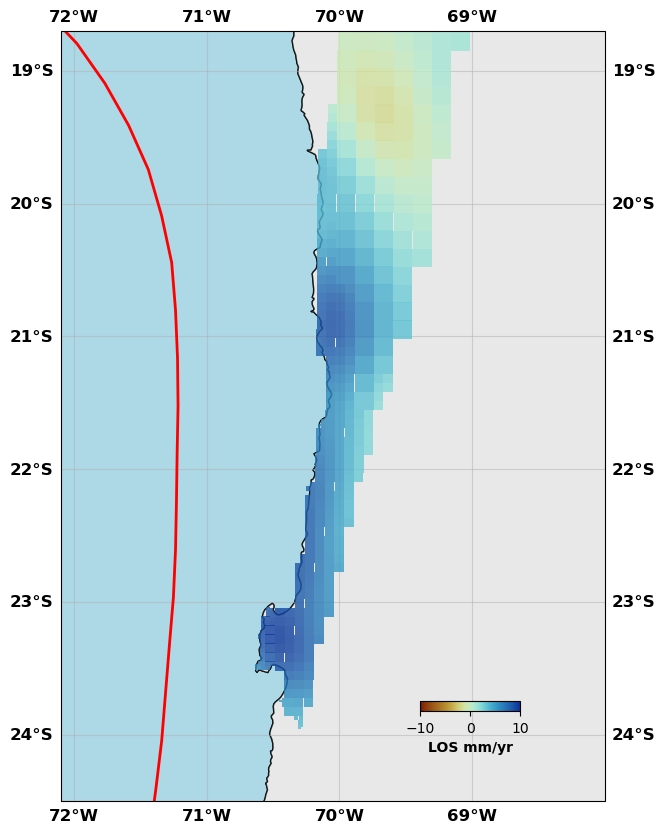

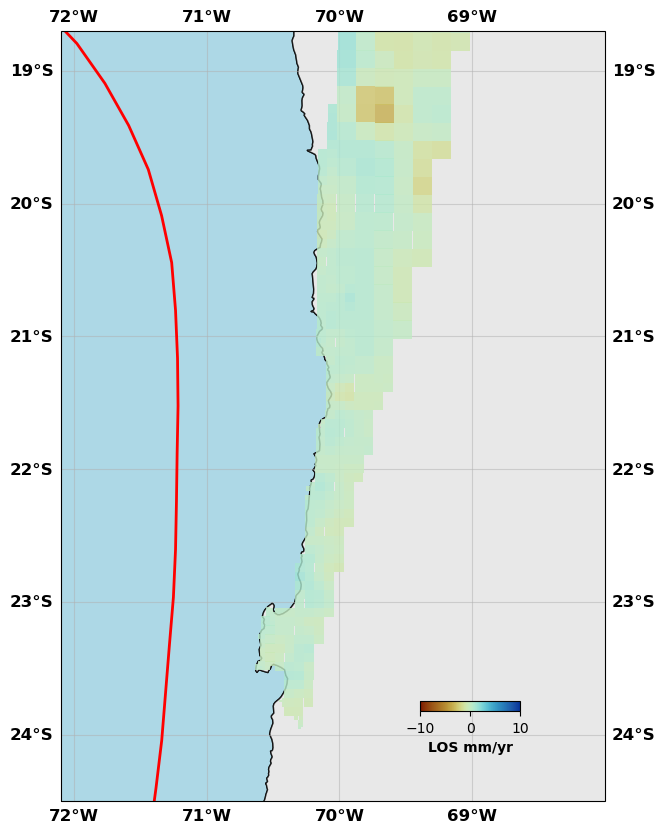

In [19]:
# Show me the InSAR data
sar.plot(plotType='decimate', data='data', faults=fault, box=[-72.1, -68., -24.5, -18.7], edgewidth=0, figsize=(10,10), cmap=cm.roma, norm=(-10,10),
         colorbar=True, cbaxis=[0.6, 0.2, 0.1, 0.01], cblabel='LOS mm/yr', seacolor='lightblue', alpha=0.8)
sar.plot(plotType='decimate', data='synth', faults=fault, box=[-72.1, -68., -24.5, -18.7], edgewidth=0, figsize=(10,10), cmap=cm.roma, norm=(-10,10),
         colorbar=True, cbaxis=[0.6, 0.2, 0.1, 0.01], cblabel='LOS mm/yr', seacolor='lightblue', alpha=0.8)
sar.plot(plotType='decimate', data='res', faults=fault, box=[-72.1, -68., -24.5, -18.7], edgewidth=0, figsize=(10,10), cmap=cm.roma, norm=(-10,10),
         colorbar=True, cbaxis=[0.6, 0.2, 0.1, 0.01], cblabel='LOS mm/yr', seacolor='lightblue', alpha=0.8)

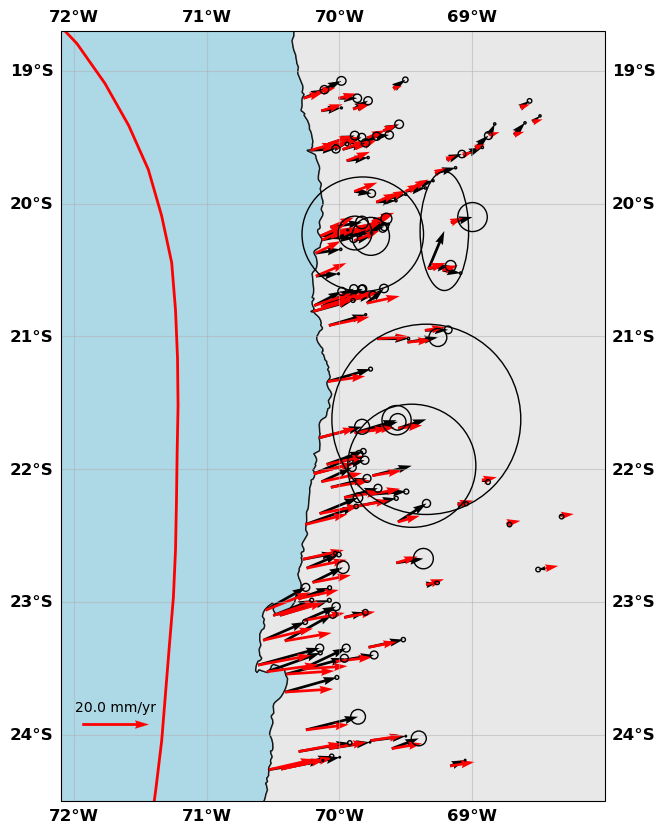

In [20]:
gnss.plot(data=['data', 'synth'], color=['k', 'r'], 
          faults=fault, figsize=(10,10), 
          seacolor='lightblue', title=None, 
          box=[-72.1, -68., -24.5, -18.7], 
          legendscale=20., legendunit='mm/yr', scale=40)

That's all folks! Lots of tuning can be done, including better smoothing, better Green's functions, better internal strain estimation. All of this is possible within CSI and the sky is the limit since you can implement what you want in CSI!